# 인물사진을 만들어 보자 [프로젝트]

# [ 목차 ]
- **Step 1. 인물모드 직접 해 보기**
- **Step 2. 사진에서 문제점 찾기**
- Step 3. 해결 방법을 제안해 보기

In [1]:
# 패키지 설치 및 버전 확인
import os
import urllib
import cv2
import numpy as np
import pixellib
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt
from importlib.metadata import version

print(cv2.__version__)
print(version('pixellib'))

4.5.3
0.7.1


## Step 1. 인물모드 직접 해 보기
- 여러분의 셀카를 이용해서 오늘 배운 내용을 수행해 봅시다. 아래와 같은 이미지를 얻어야 합니다. 최소 3장 이상의 인물모드 사진을 만들어 봅시다.
- 인물이 주인공이 아닌, 귀여운 고양이에 대한 아웃포커싱 사진도 만들어 볼 수 있을 것입니다. 시맨틱 세그멘테이션 스텝에서 힌트를 찾아봅시다.
- 배경을 blur하는 인물모드 사진이 아니라 배경사진을 다른 이미지로 교체하는 크로마키 배경 합성을 시도해 볼 수도 있을 것입니다. 여러분만의 환상적인 사진을 만들어 보면 어떨까요?

### 시맨틱 세그멘테이션 다뤄보기

(961, 720, 3)


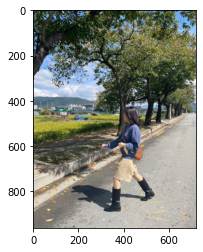

In [2]:
# 이미지 경로
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image_2.png'

# 이미지 불러오기
img_orig = cv2.imread(img_path) 

print(img_orig.shape)

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [3]:
# DeepLab 모델 준비 (PixelLib에서 제공해 주는 모델 다운로드)

# 모델 경로 생성 및 모델 저장
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 

# 다운로드 시작
urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7d656efff850>)

In [4]:
# 세그멘테이션 모델 생성
model = semantic_segmentation() # semantic segmentation을 수행하는 클래스 인스턴스
model.load_pascalvoc_model(model_file) # pascal voc에 대해 훈련된 예외 모델(model_file)을 로드하는 함수

In [5]:
# 모델에 이미지 입력
segvalues, output = model.segmentAsPascalvoc(img_path) # segmentAsPascalvoc()함수를 호출하여 입력된 이미지 분할

In [6]:
#pascalvoc 데이터의 라벨 종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

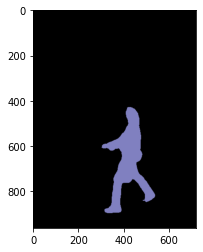

In [7]:
# 분할한 이미지의 결과값
plt.imshow(output)
plt.show()

In [8]:
# 분할한 이미지의 배열값
segvalues

{'class_ids': array([ 0, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [9]:
# class_ids로 pacalvoc에 담겨있는 라벨 출력
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
person


In [10]:
# 컬러맵 만들기 
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3
    
colormap[15] # 컬러맵 15에 해당하는 배열 출력 (person)

array([192, 128, 128])

(961, 720)


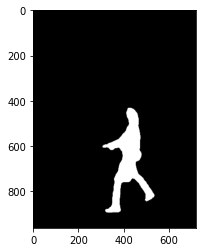

In [11]:
# 색상 순서 변경 (colormap의 배열은 RGB 순, output의 배열은 BGR 순)
seg_color = (128,128,192)

seg_map = np.all(output==seg_color, axis=-1) 
print(seg_map.shape) 
plt.imshow(seg_map, cmap='gray')
plt.show()

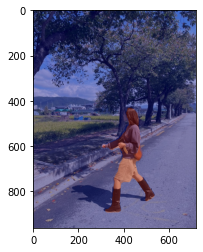

In [12]:
# 원본이미지를 img_show에 할당
img_show = img_orig.copy()

# 사람이 있는 위치와 배경을 분리해서 표현한 color_mask 만들기
img_mask = seg_map.astype(np.uint8) * 255 # # True=255, False=0으로 변경

# 255와 0을 적당한 색상으로 바꿔보기
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본이미지와 마스크 합치기
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0) # # 0.6과 0.4는 두 이미지를 섞는 비율

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

### 배경 흐리게 하기

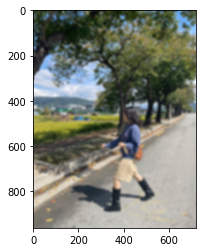

In [13]:
img_orig_blur = cv2.blur(img_orig, (13,13)) # (13,13)은 blurring kernel size

plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB)) # BGR → RGB로 변환
plt.show()

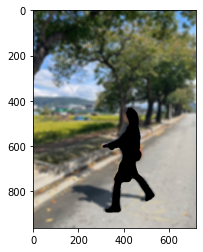

In [14]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR) # BGR → RGB로 변환

img_bg_mask = cv2.bitwise_not(img_mask_color) # 이미지 반전 (배경=0,사람=255 → 배경=255,사람=0)

img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask) # 배경만 있는 영상 얻기

plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

### 흐린 배경과 원본 영상 합성

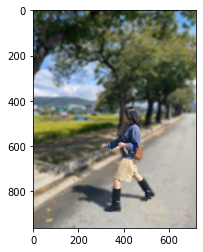

In [15]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur) # 조건에 따라 블러 처리

plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

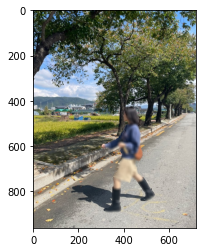

In [16]:
img_concat = np.where(img_mask_color==255, img_orig_blur, img_orig)

plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

### 크로마키 배경 합성

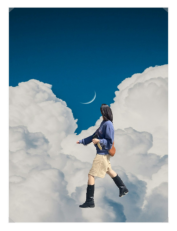

In [17]:
# 1. 새 배경 이미지 불러오기
new_bg_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/background.png'
new_bg = cv2.imread(new_bg_path)

# 2. 원본 이미지와 새 배경 이미지 크기 맞추기
new_bg = cv2.resize(new_bg, (img_orig.shape[1], img_orig.shape[0]))

# 3. 배경만 마스킹
img_bg_new = np.where(img_mask_color==0, new_bg, 0)  # 사람이 아닌 부분은 배경 이미지

# 4. 사람만 마스킹
img_person = np.where(img_mask_color==255, img_orig, 0)  # 사람 부분은 원본 이미지

# 5. 배경과 사람 합성
img_result = cv2.add(img_bg_new, img_person)

# 6. 결과 출력
plt.imshow(cv2.cvtColor(img_result, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

### 배경을 흑백으로 처리

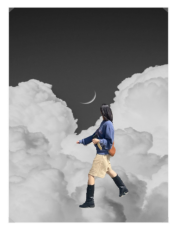

In [18]:
# 1. 배경을 흑백으로 변환
new_bg_gray = cv2.cvtColor(new_bg, cv2.COLOR_BGR2GRAY)
new_bg_gray = cv2.cvtColor(new_bg_gray, cv2.COLOR_GRAY2BGR)  # 다시 3채널로 변환

# 2. 배경만 마스킹 (흑백 배경)
img_bg_gray = np.where(img_mask_color==0, new_bg_gray, 0)

# 3. 사람만 마스킹
img_person = np.where(img_mask_color==255, img_orig, 0)

# 4. 합성
img_result = cv2.add(img_bg_gray, img_person)

plt.imshow(cv2.cvtColor(img_result, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

### 배경을 세피아톤으로 처리

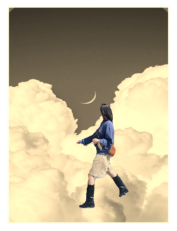

In [19]:
# 세피아 필터 함수
def apply_sepia(image):
    sepia_filter = np.array([[0.272, 0.534, 0.131],
                              [0.349, 0.686, 0.168],
                              [0.393, 0.769, 0.189]])
    sepia_image = cv2.transform(image, sepia_filter)
    sepia_image = np.clip(sepia_image, 0, 255).astype(np.uint8)
    return sepia_image

# 1. 배경을 세피아톤으로 변환
new_bg_sepia = apply_sepia(new_bg)

# 2. 배경만 마스킹
img_bg_sepia = np.where(img_mask_color==0, new_bg_sepia, 0)

# 3. 사람만 마스킹
img_person = np.where(img_mask_color==255, img_orig, 0)

# 4. 합성
img_result = cv2.add(img_bg_sepia, img_person)

plt.imshow(cv2.cvtColor(img_result, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

## Step 2. 사진에서 문제점 찾기
- 여러분이 만들어 낸 인물 모드 사진 중 하나에서도 이상한 위치를 찾아 표시해 봅시다. 
- 표시한 이미지들을 jupyter notebook에 포함하여 제출해 주세요.

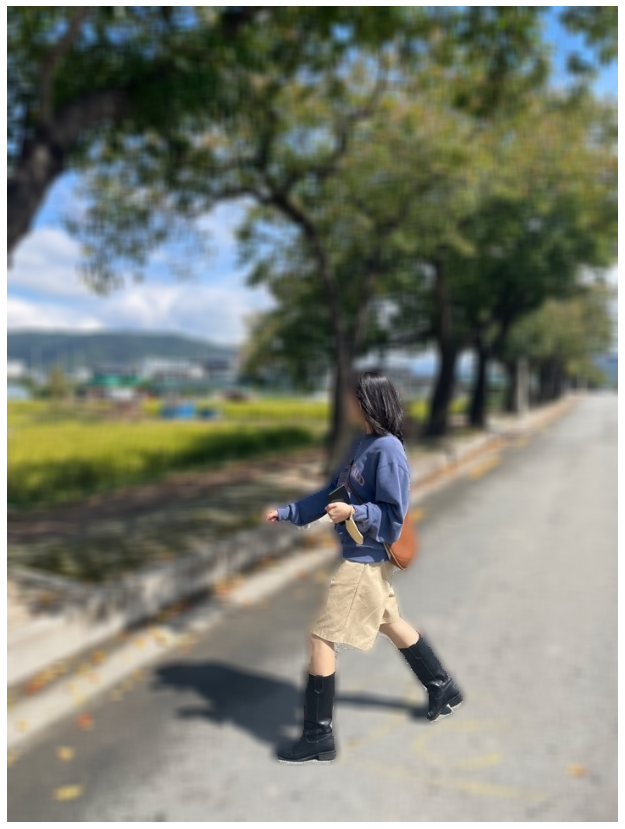

In [20]:
# 인물 모드 사진 불러오기 (흐린 배경 + 원본 합성 이미지)
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)

plt.figure(figsize=(15, 15))
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

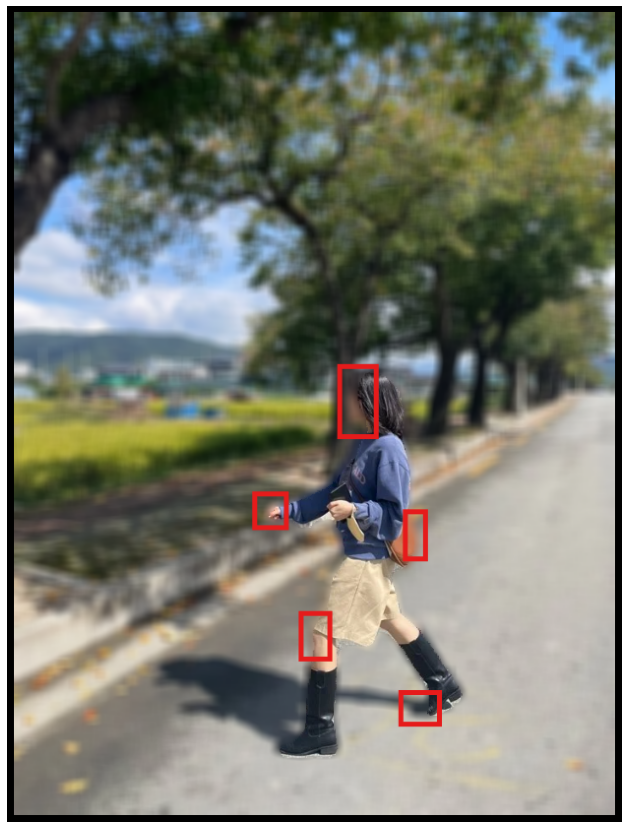

In [21]:
# 이상지점을 표시한 이미지 경로
img_path_2 = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image_2_blur.png'

# 이상지점을 표시한 이미지 불러오기
img_concat = cv2.imread(img_path_2)

plt.figure(figsize=(15, 15))
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

### 문제점 분석


**1. 세그멘테이션의 부정확성**

- 얼굴, 손, 가방, 신발 등 디테일한 영역이 정확히 인식되지 않음
- 경계가 매끄럽지 않아 인물과 배경의 경계가 부자연스러움

**2. 심도 인식의 한계**

- 단순히 세그멘테이션만으로는 심도 정보가 부족해 자연스러운 보케 효과가 어려움

**3. 세밀한 객체 인식 부족**

- 작은 객체(예: 손, 얼굴의 미세한 부분 등)가 세그멘테이션에서 잘리지 않거나 엉뚱하게 포함됨